# ATIVIDADE PRÁTICA

##### NOME DA DISCIPLINA: LINGUAGEM DE PROGRAMAÇÃO
##### Unidade: 3 – INTRODUÇÃO À ANÁLISE DE DADOS COM PYTHON
##### Aula: 4 – VISUALIZAÇÃO DE DADOS EM PYTHON


### Objetivo
Analisar e visualizar o desempenho anual de vendas de uma empresa varejista utilizando SQLite, Pandas, Matplotlib e Seaborn.


### Roteiro
1. Preparar o banco e carregar os dados de exemplo.  
2. Ler os registros para um DataFrame e criar colunas derivadas.  
3. Calcular métricas agregadas por dia, mês, categoria e produto.  
4. Visualizar resultados em painéis comparativos.  
5. Gerar análises adicionais (distribuição, dispersão, heatmap).  
6. Resumir os principais insights para o negócio.


In [1]:
# Imports e configuração global
import sqlite3
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

sns.set_theme(style="whitegrid")
DB_PATH = Path("dados_vendas.db")


### Bloco para executar dos das definições de CRUD do Banco de Dados

In [2]:
# Funções utilitárias para o banco de dados
def init_db(db_path: Path = DB_PATH) -> None:
    """Garante que a tabela de vendas exista antes das inserções."""
    with sqlite3.connect(db_path) as conn:
        conn.execute(
            """
            CREATE TABLE IF NOT EXISTS vendas1 (
                id_venda    INTEGER PRIMARY KEY,
                data_venda  DATE,
                produto     TEXT,
                categoria   TEXT,
                valor_venda REAL
            )
            """
        )
    print("Banco e tabela prontos.")


def insert_many(registros, db_path: Path = DB_PATH) -> None:
    """Insere registros no formato (data_venda, produto, categoria, valor_venda)."""
    with sqlite3.connect(db_path, timeout=15) as conn:
        try:
            conn.executemany(
                """
                INSERT INTO vendas1 (data_venda, produto, categoria, valor_venda)
                VALUES (?, ?, ?, ?)
                """,
                registros,
            )
            print(f"{len(registros)} linhas inseridas.")
        except sqlite3.IntegrityError as exc:
            print("Falha ao inserir (restrição do banco):", exc)


def listar_registros(db_path: Path = DB_PATH) -> None:
    """Mostra todos os registros atuais da tabela para conferência rápida."""
    with sqlite3.connect(db_path) as conn:
        rows = conn.execute("SELECT * FROM vendas1 ORDER BY id_venda").fetchall()

    if not rows:
        print("Tabela vazia.")
        return

    for linha in rows:
        print(linha)


def atualizar_excluir(registro, acao: str, db_path: Path = DB_PATH) -> None:
    """
    Atualiza (UP) ou exclui (EX) registros.
    - UP: aceita tupla com 4 campos (insert sem id) ou 5 campos (upsert com id).
    - EX: aceita tupla contendo somente o id_venda.
    """
    acao = (acao or "").upper()
    if acao not in {"UP", "EX"}:
        raise ValueError("Ação deve ser 'UP' ou 'EX'.")

    with sqlite3.connect(db_path) as conn:
        if acao == "UP":
            if len(registro) == 5:
                conn.execute(
                    """
                    INSERT INTO vendas1 (id_venda, data_venda, produto, categoria, valor_venda)
                    VALUES (?, ?, ?, ?, ?)
                    ON CONFLICT(id_venda) DO UPDATE SET
                        data_venda  = excluded.data_venda,
                        produto     = excluded.produto,
                        categoria   = excluded.categoria,
                        valor_venda = excluded.valor_venda
                    """,
                    registro,
                )
                print(f"Registro {registro[0]} inserido/atualizado.")
            elif len(registro) == 4:
                conn.execute(
                    """
                    INSERT INTO vendas1 (data_venda, produto, categoria, valor_venda)
                    VALUES (?, ?, ?, ?)
                    """,
                    registro,
                )
                print("Registro inserido (id gerado automaticamente).")
            else:
                raise ValueError("Formato inválido para UP.")
        else:  # EX
            if not registro:
                raise ValueError("Informe o id_venda para excluir.")
            id_venda = registro[0]
            cur = conn.execute("DELETE FROM vendas1 WHERE id_venda = ?", (id_venda,))
            if cur.rowcount:
                print(f"Registro {id_venda} excluído.")
            else:
                print(f"id_venda {id_venda} não encontrado.")


In [3]:
# Execução inicial (apenas para ambientes de aula)
init_db()
dados_demo = [
    ("2023-01-01", "Produto A", "Eletrônicos", 1500.00),
    ("2023-01-05", "Produto B", "Roupas", 350.00),
    ("2023-02-10", "Produto C", "Eletrônicos", 1200.00),
    ("2023-03-15", "Produto D", "Livros", 200.00),
    ("2023-03-20", "Produto E", "Eletrônicos", 800.00),
    ("2023-04-02", "Produto F", "Roupas", 400.00),
    ("2023-05-05", "Produto G", "Livros", 150.00),
    ("2023-06-10", "Produto H", "Eletrônicos", 1000.00),
    ("2023-07-20", "Produto I", "Roupas", 600.00),
    ("2023-08-25", "Produto J", "Eletrônicos", 700.00),
    ("2023-09-30", "Produto K", "Livros", 300.00),
    ("2023-10-05", "Produto L", "Roupas", 450.00),
    ("2023-11-15", "Produto M", "Eletrônicos", 900.00),
    ("2023-12-20", "Produto N", "Livros", 250.00)
]
insert_many(dados_demo)
listar_registros()


Banco e tabela prontos.
14 linhas inseridas.
(1, '2023-01-01', 'Produto A', 'Eletrônicos', 1500.0)
(2, '2023-01-05', 'Produto B', 'Roupas', 350.0)
(3, '2023-02-10', 'Produto C', 'Eletrônicos', 1200.0)
(4, '2023-03-15', 'Produto D', 'Livros', 200.0)
(5, '2023-03-20', 'Produto E', 'Eletrônicos', 800.0)
(6, '2023-04-02', 'Produto F', 'Roupas', 400.0)
(7, '2023-05-05', 'Produto G', 'Livros', 150.0)
(8, '2023-06-10', 'Produto H', 'Eletrônicos', 1000.0)
(9, '2023-07-20', 'Produto I', 'Roupas', 600.0)
(10, '2023-08-25', 'Produto J', 'Eletrônicos', 700.0)
(11, '2023-09-30', 'Produto K', 'Livros', 300.0)
(12, '2023-10-05', 'Produto L', 'Roupas', 450.0)
(13, '2023-11-15', 'Produto M', 'Eletrônicos', 900.0)
(14, '2023-12-20', 'Produto N', 'Livros', 250.0)


In [4]:
# Carga dos dados e engenharia de atributos temporais
with sqlite3.connect(DB_PATH) as conn:
    df = pd.read_sql_query("SELECT * FROM vendas1", conn, parse_dates=["data_venda"])

df["ano"] = df["data_venda"].dt.year
df["mes"] = df["data_venda"].dt.month
df["ano_mes"] = df["data_venda"].dt.to_period("M").astype(str)
df["dia_semana"] = (
    df["data_venda"].dt.day_name(locale="pt_BR.UTF-8").str.capitalize()
)

display(df.head())
df.dtypes


,id_venda,data_venda,produto,categoria,valor_venda,ano,mes,ano_mes,dia_semana
0,1,2023-01-01,Produto A,Eletrônicos,1500.0,2023,1,2023-01,Domingo
1,2,2023-01-05,Produto B,Roupas,350.0,2023,1,2023-01,Quinta-feira
2,3,2023-02-10,Produto C,Eletrônicos,1200.0,2023,2,2023-02,Sexta-feira
3,4,2023-03-15,Produto D,Livros,200.0,2023,3,2023-03,Quarta-feira
4,5,2023-03-20,Produto E,Eletrônicos,800.0,2023,3,2023-03,Segunda-feira


id_venda                int64
data_venda     datetime64[ns]
produto                object
categoria              object
valor_venda           float64
ano                     int32
mes                     int32
ano_mes                object
dia_semana             object
dtype: object

In [5]:
# Agregações principais para os gráficos
vendas_diarias = df.groupby("data_venda", as_index=False)["valor_venda"].sum()

vendas_mensais = df.groupby("ano_mes", as_index=False)["valor_venda"].sum()

vendas_categoria = (
    df.groupby("categoria", as_index=False)["valor_venda"]
      .sum()
      .assign(percentual=lambda x: (x["valor_venda"] / x["valor_venda"].sum() * 100).round(2))
)

vendas_por_produto = df.groupby("produto", as_index=False)["valor_venda"].sum()

vendas_por_mes_categoria = (
    df.groupby(["ano_mes", "categoria"], as_index=False)["valor_venda"].sum()
)

df_cumulativo = (
    df.sort_values("data_venda")[["data_venda", "valor_venda"]]
      .assign(valor_acumulado=lambda x: x["valor_venda"].cumsum(),
              ano_mes=lambda x: x["data_venda"].dt.to_period("M").astype(str))
)


C:\Users\robso\AppData\Local\Temp\ipykernel_19268\2565417981.py:5: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  ax0.plot_date(vendas_diarias["data_venda"], vendas_diarias["valor_venda"], linestyle="solid")


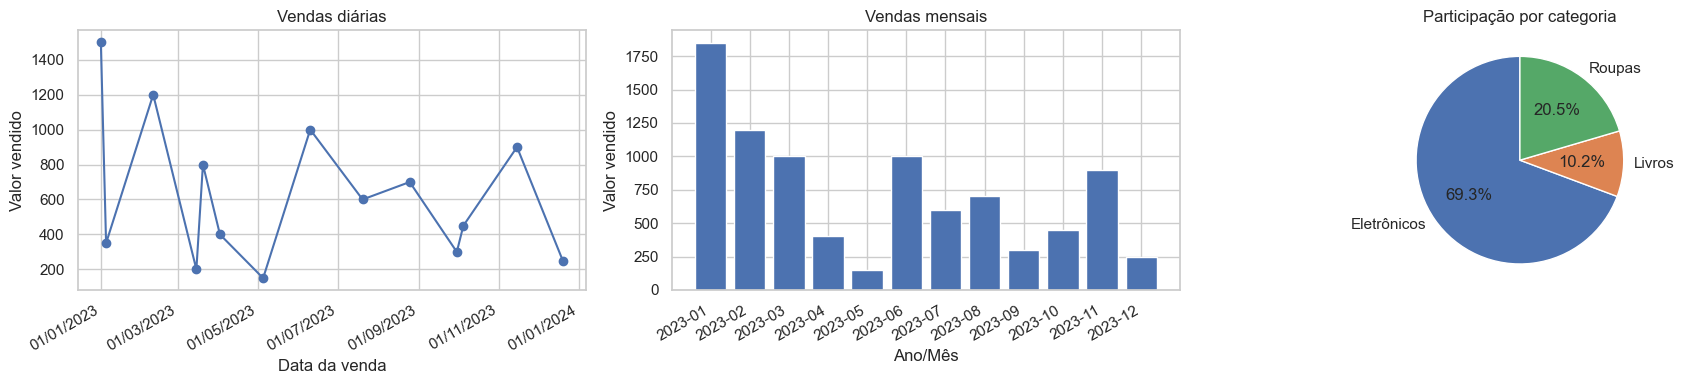

In [6]:
# Painel com vendas diárias, mensais e participação por categoria
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

ax0 = ax[0]
ax0.plot_date(vendas_diarias["data_venda"], vendas_diarias["valor_venda"], linestyle="solid")
ax0.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%Y"))
fig.autofmt_xdate()
ax0.set_xlabel("Data da venda")
ax0.set_ylabel("Valor vendido")
ax0.set_title("Vendas diárias")

ax1 = ax[1]
ax1.bar(vendas_mensais["ano_mes"], vendas_mensais["valor_venda"], color="#4C72B0")
ax1.set_xlabel("Ano/Mês")
ax1.set_ylabel("Valor vendido")
ax1.set_title("Vendas mensais")

ax2 = ax[2]
ax2.pie(
    vendas_categoria["percentual"],
    labels=vendas_categoria["categoria"],
    autopct="%1.1f%%",
    startangle=90,
)
ax2.set_title("Participação por categoria")

fig.tight_layout()
plt.show()


C:\Users\robso\AppData\Local\Temp\ipykernel_19268\888533543.py:5: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  ax0.plot_date(df_cumulativo["data_venda"], df_cumulativo["valor_acumulado"], linestyle="solid")


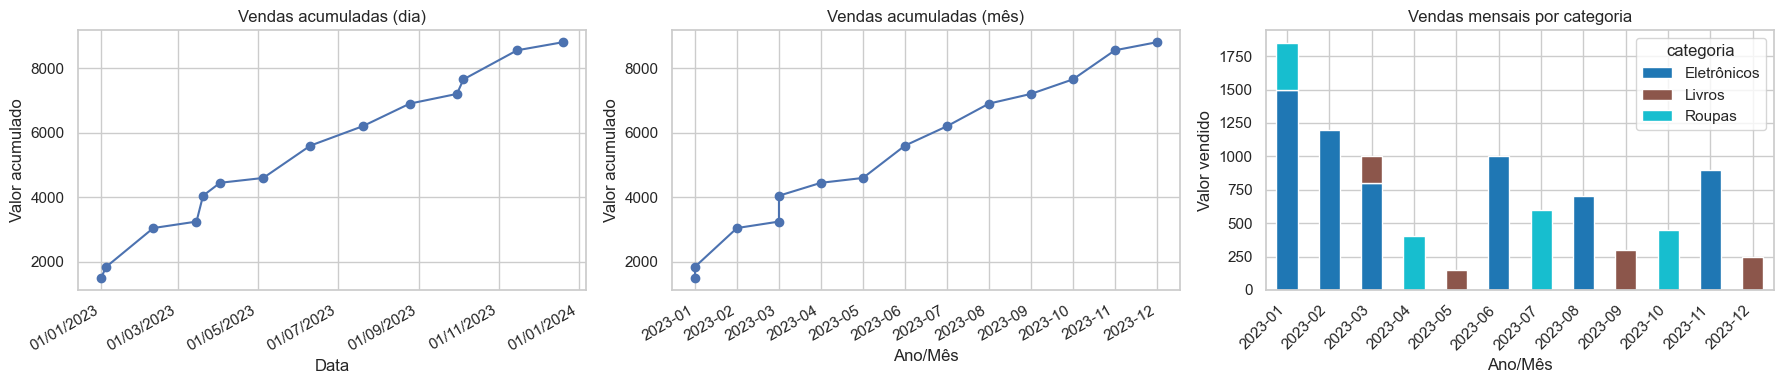

In [7]:
# Evolução acumulada e barras empilhadas por categoria
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

ax0 = ax[0]
ax0.plot_date(df_cumulativo["data_venda"], df_cumulativo["valor_acumulado"], linestyle="solid")
ax0.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%Y"))
fig.autofmt_xdate()
ax0.set_title("Vendas acumuladas (dia)")
ax0.set_xlabel("Data")
ax0.set_ylabel("Valor acumulado")

ax1 = ax[1]
ax1.plot(df_cumulativo["ano_mes"], df_cumulativo["valor_acumulado"], marker="o")
ax1.set_title("Vendas acumuladas (mês)")
ax1.set_xlabel("Ano/Mês")
ax1.set_ylabel("Valor acumulado")

tabela_empilhada = (
    vendas_por_mes_categoria
    .pivot(index="ano_mes", columns="categoria", values="valor_venda")
    .fillna(0)
)

tabela_empilhada.plot(kind="bar", stacked=True, colormap="tab10", ax=ax[2])
ax[2].set_title("Vendas mensais por categoria")
ax[2].set_xlabel("Ano/Mês")
ax[2].set_ylabel("Valor vendido")
ax[2].tick_params(axis="x", rotation=45)

fig.tight_layout()
plt.show()


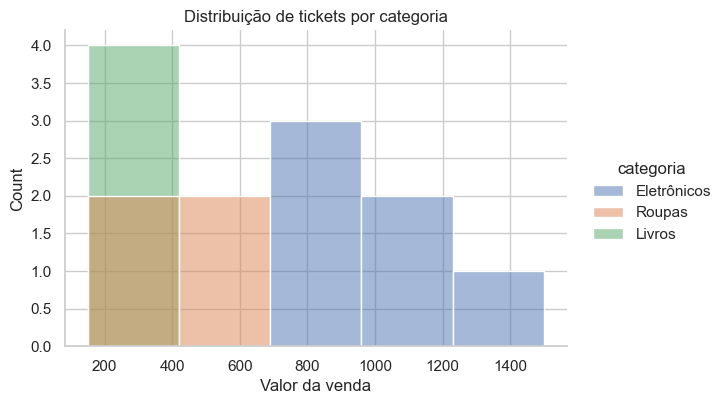

In [8]:
# Distribuição dos tickets por categoria
sns.displot(df, x="valor_venda", hue="categoria", height=4, aspect=1.5)
plt.xlabel("Valor da venda")
plt.title("Distribuição de tickets por categoria")
plt.show()


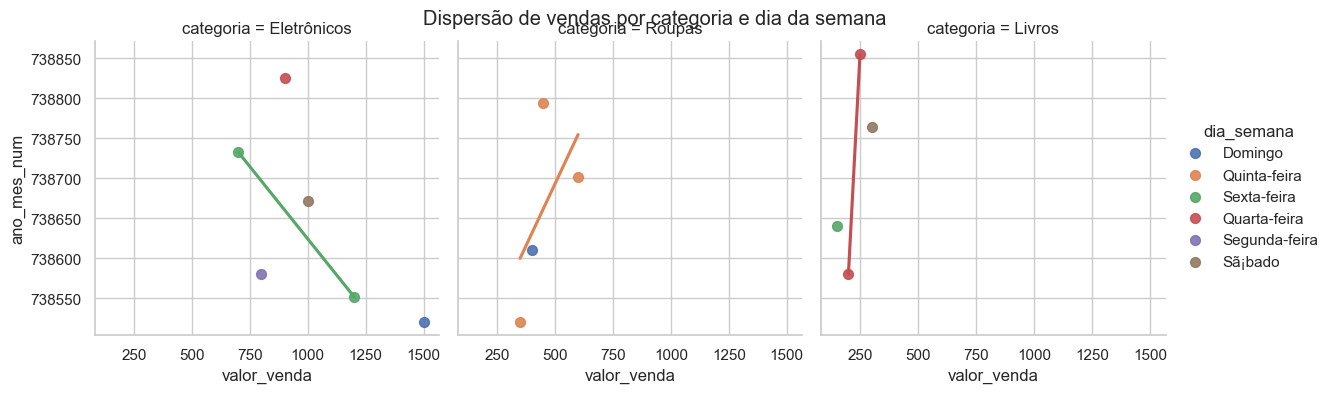

In [9]:
# Dispersão dos tickets por mês, destacando dia da semana
df["ano_mes_num"] = pd.to_datetime(df["ano_mes"]).map(pd.Timestamp.toordinal)

sns.lmplot(
    data=df,
    x="valor_venda",
    y="ano_mes_num",
    col="categoria",
    hue="dia_semana",
    col_wrap=3,
    ci=None,
    height=4,
    scatter_kws={"s": 50, "alpha": 0.9},
)

plt.subplots_adjust(top=0.9)
plt.suptitle("Dispersão de vendas por categoria e dia da semana")
plt.show()


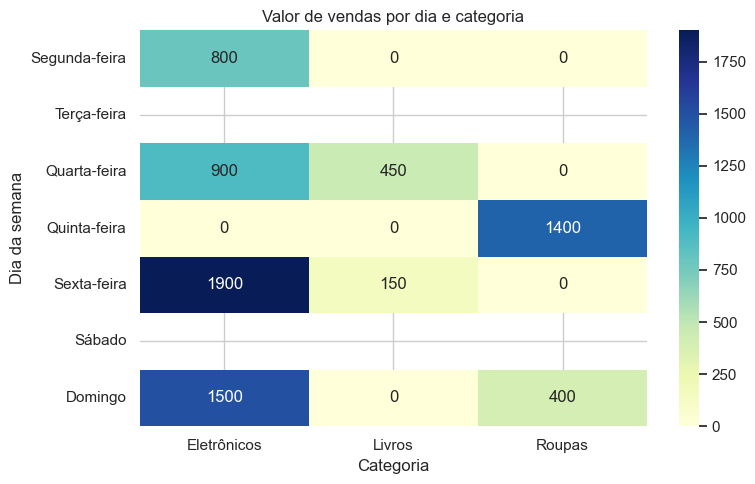

In [10]:
# Heatmap de valor vendido por dia da semana e categoria
ordem_dias = [
    "Segunda-feira", "Terça-feira", "Quarta-feira",
    "Quinta-feira", "Sexta-feira", "Sábado", "Domingo"
]

tabela_heatmap = (
    df.groupby(["dia_semana", "categoria"])["valor_venda"]
      .sum()
      .unstack(fill_value=0)
      .reindex(ordem_dias)
)

plt.figure(figsize=(8, 5))
sns.heatmap(tabela_heatmap, annot=True, fmt=".0f", cmap="YlGnBu")
plt.xlabel("Categoria")
plt.ylabel("Dia da semana")
plt.title("Valor de vendas por dia e categoria")
plt.tight_layout()
plt.show()


In [11]:
# Consolidação de indicadores para o relatório
numero_registros = df["id_venda"].count()
mes_maior_venda = vendas_mensais.loc[vendas_mensais["valor_venda"].idxmax(), "ano_mes"]
categoria_lider = vendas_categoria.loc[vendas_categoria["valor_venda"].idxmax(), "categoria"]

print("=== Resumo de Insights ===\n")
print(f"Registros analisados: {numero_registros}")
print(f"Mês de maior venda: {mes_maior_venda}")
print(f"Categoria líder em receita: {categoria_lider}")
print("\n=== Recomendações ===\n")
print("* Fortalecer campanhas de eletrônicos no primeiro trimestre.")
print("* Investigar queda de vendas após março e testar promoções sazonais.")
print("* Explorar ações específicas para livros em quartas e sextas, e para roupas em quintas e domingos.")
print("* Monitorar mix de categorias ao longo do ano para balancear ticket médio.")


=== Resumo de Insights ===

Registros analisados: 14
Mês de maior venda: 2023-01
Categoria líder em receita: Eletrônicos

=== Recomendações ===

* Fortalecer campanhas de eletrônicos no primeiro trimestre.
* Investigar queda de vendas após março e testar promoções sazonais.
* Explorar ações específicas para livros em quartas e sextas, e para roupas em quintas e domingos.
* Monitorar mix de categorias ao longo do ano para balancear ticket médio.
